# `sbi`
In this notebook we'll explore SBI techniques such as neural posterior estimation and neural likelihood estimation using the `sbi` python package: https://sbi.readthedocs.io/en/latest/

To install the package use
```
python -m pip install sbi
```
in your conda environment. Beware of some pesky `torch` and `jupyter` version requirements that may conflict.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import corner

In [2]:
import sbi
import torch

In [3]:
np.random.seed(10)

# Example 0
Let's return to the example from a few weeks ago

> Imagine a hypothetical simplistic example, where we point our telescope to observe the light from a single star with true flux $F_{\rm true}$, which remains constant with time. We will ignore any systematic errors. We perform $N$ measurements with our telescope, where the $i^{\rm th}$ measurement report an observed flux $F_i$ with uncertainty/error $e_i$.

Lets generate a synthetic observation

In [4]:
F_true = 1000
F_obs = np.random.poisson(lam=F_true)

Let's write down the a simulation of the data generation process. In this case this is trivial because we know exactly the data generation process

In [5]:
def simulation(F_true): 
    return np.random.poisson(lam=F_true)

First, we want to sample $(\theta', \mathcal{D}') \sim p(\theta, \mathcal{D})$


As in ABC, this involves repeating two steps
1. sample the prior: $\theta'\sim p(\theta)$
2. run simulation: $\mathcal{D}' \sim F(\theta')$

For our prior, lets use
$$p(\theta) = \mathcal{N}(1002, 4)$$

In [6]:
def sample_prior(): 
    # sample prior
    return 1002. + 4. * np.random.normal()

In [7]:
Nsample = 10000

samples = np.zeros((Nsample, 2))
for i in range(Nsample): 
    theta_p = sample_prior()
    data_p = simulation(theta_p)
    samples[i,:] = np.array([theta_p, data_p])
samples = torch.tensor(samples, dtype=torch.float32)

Text(0, 0.5, '$\\mathcal{D}$')

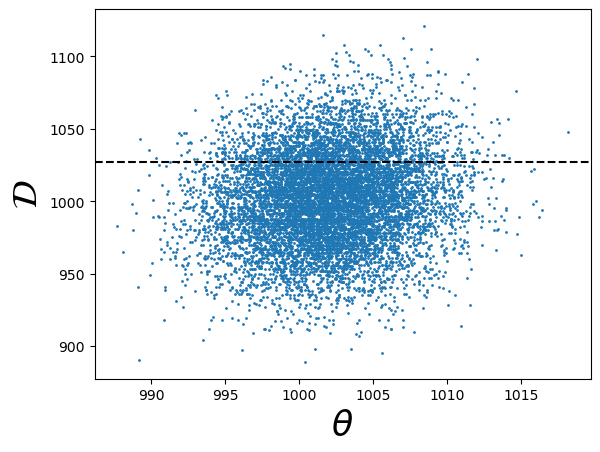

In [8]:
plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), s=1)
plt.axhline(F_obs, c='k', linestyle='--')
plt.xlabel(r'$\theta$', fontsize=25)
plt.ylabel(r'$\mathcal{D}$', fontsize=25)

Now lets use **neural posterior estimation** to directly estimate the posterior with a neural density estimator

In [9]:
from sbi.utils import BoxUniform
from sbi.inference import NPE

In [10]:
# the `sbi` package requires specifying bounds for the parameter space. 
# Here's we'll choose conservative bounds that go well beyond the prior: [0, 2000]
_range = BoxUniform(low=torch.tensor([0.], dtype=torch.float32), high=torch.tensor([2000.], dtype=torch.float32))

# `sbi` package has a convenient `NPE` inference object. You can specify the neural density estimator. Here we'll initially use MADE
made = NPE(_range, density_estimator='made')

# append (theta, D) from the simulations
_ = made.append_simulations(samples[:,0][:,None], samples[:,1][:,None])

In [11]:
# train NPE. 
npe_made = made.train()

 Neural network successfully converged after 31 epochs.

In [12]:
posterior_made = made.build_posterior()

In [13]:
q_samples0 = posterior_made.sample((10000,), x=F_obs)

  0%|          | 0/10000 [00:00<?, ?it/s]

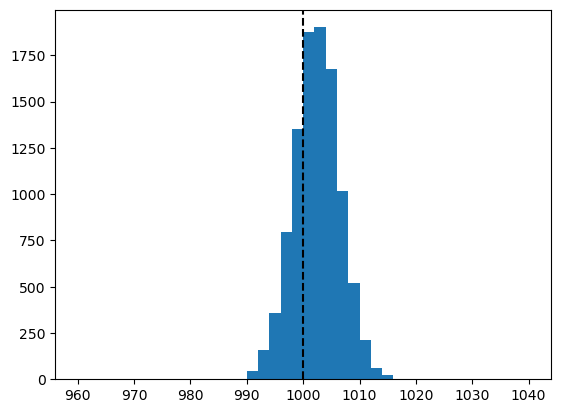

In [14]:
plt.hist(q_samples0, range=(960, 1040), bins=40)
plt.axvline(F_true, color='k', linestyle='--')

Since the `sbi` package makes it very convenient to try different neural density estimators, now lets try with MAF. 

In [15]:
maf = NPE(_range, density_estimator='maf')

# append (theta, D) from the simulations
_ = maf.append_simulations(torch.tensor(samples[:,0][:,None], dtype=torch.float32), torch.tensor(samples[:,1][:,None], dtype=torch.float32))
# train NPE. 
npe_maf = maf.train()
posterior_maf = maf.build_posterior()

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_91237/1336823689.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _ = maf.append_simulations(torch.tensor(samples[:,0][:,None], dtype=torch.float32), torch.tensor(samples[:,1][:,None], dtype=torch.float32))
/opt/homebrew/Caskroom/miniconda/base/envs/astro-ai/lib/python3.11/site-packages/sbi/neural_nets/net_builders/flow.py:149: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 32 epochs.

In [16]:
q_samples1 = posterior_made.sample((10000,), x=F_obs)

  0%|          | 0/10000 [00:00<?, ?it/s]

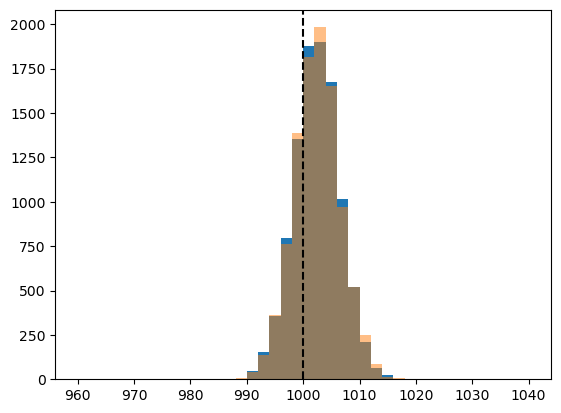

In [17]:
plt.hist(q_samples0, range=(960, 1040), bins=40)
plt.hist(q_samples1, range=(960, 1040), bins=40, alpha=0.5)
plt.axvline(F_true, color='k', linestyle='--')

# Example 1
Now that was a very simple 1D example. Lets consider a slightly more interesting example of fitting a line to some data and see how SBI with variational inferenceh olds up. First, we'll go through the example with a slight modification: Gaussian priors rather than uniform priors. 

In [18]:
a_true, b_true = 0, 1.75
x = np.array([1, 1.5, 2, 2.5])
y = np.array([1.87640523, 2.59001572, 3.4978738 , 4.47408932])
yerr = 0.1

<ErrorbarContainer object of 3 artists>

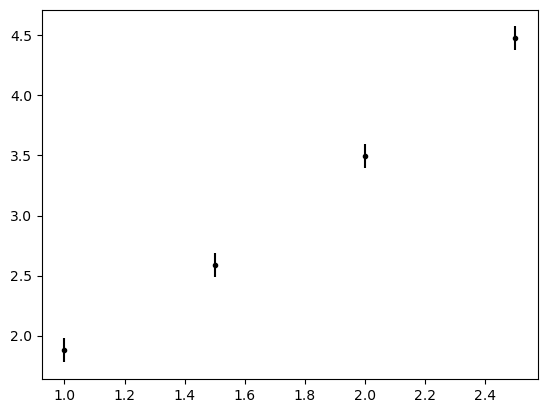

In [19]:
plt.errorbar(x, y, yerr=yerr, fmt='.k')

In [20]:
def simulation(theta): 
    a, b = theta
    noise = yerr * np.random.normal(size=len(x))
    return a + b * x + noise

def sample_prior(): 
    # sample a and b from uniform prior
    _a = -0.5 + np.random.normal() 
    _b = 5 + 3*np.random.normal()
    return [_a, _b]

same as above, sample $(\theta', \mathcal{D}') \sim p(\theta, \mathcal{D})$

In [21]:
Nsample = 500000

samples = np.zeros((Nsample, 6))
for i in range(Nsample): 
    theta_p = sample_prior()
    data_p = simulation(theta_p)
    samples[i,:] = np.concatenate([theta_p, data_p])
samples = torch.tensor(samples, dtype=torch.float32)

In [29]:
_range = BoxUniform(low=torch.tensor([-10., -10], dtype=torch.float32), high=torch.tensor([10., 100.], dtype=torch.float32))

maf = NPE(_range, density_estimator='maf')

# append (theta, D) from the simulations
_ = maf.append_simulations(samples[:,:2], samples[:,2:])
# train NPE. 
npe_maf = maf.train()
posterior_maf = maf.build_posterior()

 Neural network successfully converged after 75 epochs.

In [30]:
q_samples = posterior_maf.sample((10000,), x=torch.tensor(y, dtype=torch.float32))

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_91237/2934160455.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(q_samples.cpu()), labels=['a', 'b'])


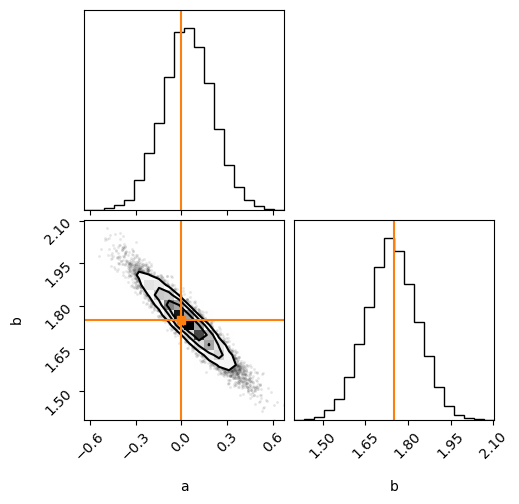

In [31]:
fig = corner.corner(np.array(q_samples.cpu()), labels=['a', 'b'])
corner.overplot_lines(fig, [a_true, b_true], color="C1")
corner.overplot_points(fig, np.array([a_true, b_true])[None], marker="s", color="C1")

# Example 1.b
Now what happens if we change the prior back to the uniform priors

In [33]:
def simulation(theta): 
    a, b = theta
    noise = yerr * np.random.normal(size=len(x))
    return a + b * x + noise

def sample_prior(): 
    # sample a and b from uniform prior
    _a = -0.5 + np.random.uniform() 
    _b = 10*np.random.uniform()
    return [_a, _b]

Nsample = 500000

samples = np.zeros((Nsample, 6))
for i in range(Nsample): 
    theta_p = sample_prior()
    data_p = simulation(theta_p)
    samples[i,:] = np.concatenate([theta_p, data_p])
samples = torch.tensor(samples, dtype=torch.float32)

In [34]:
_range = BoxUniform(low=torch.tensor([-10., -10], dtype=torch.float32), high=torch.tensor([10., 100.], dtype=torch.float32))

maf = NPE(_range, density_estimator='maf')

# append (theta, D) from the simulations
_ = maf.append_simulations(samples[:,:2], samples[:,2:])
# train NPE. 
npe_maf = maf.train()
posterior_maf = maf.build_posterior()

 Neural network successfully converged after 54 epochs.

In [35]:
q_samples = posterior_maf.sample((10000,), x=torch.tensor(y, dtype=torch.float32))

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_91237/2934160455.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(q_samples.cpu()), labels=['a', 'b'])


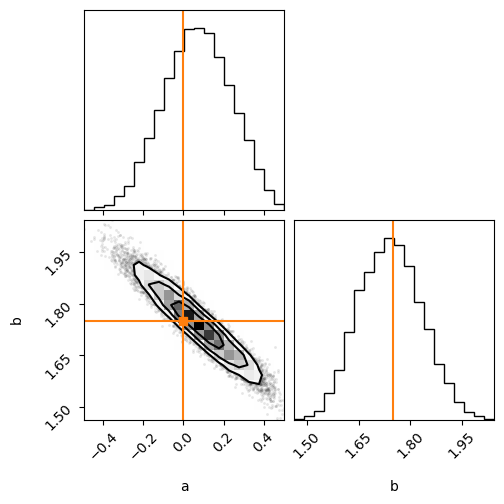

In [36]:
fig = corner.corner(np.array(q_samples.cpu()), labels=['a', 'b'])
corner.overplot_lines(fig, [a_true, b_true], color="C1")
corner.overplot_points(fig, np.array([a_true, b_true])[None], marker="s", color="C1")